In [43]:
#import libraries and such
from collections import deque
from random import random
import math
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.stats import expon
import seaborn as sns
import scipy.stats as stats

In [19]:
class Queue(deque):
    # initializing a queue, inherits from deque class
    def __init__(self, ID, nextTime):
        deque.__init__(self, (), None)
        self.ID = ID
        self.history = []
        self.nextTime = nextTime

    # record the queue length at a moment in time
    def recordQueueLength(self, time):
        self.history.append([time, len(self)])

class Car:
    # initializing a car
    def __init__(self, time):
        # store variables on instance
        self.traveled = 0
        self.history = []
        self.t_arrival = time
        # update the static properties

    # traverse an intersection
    def traverse(self, ID):
        self.history.append(ID)  # record where it's been for debugging
        self.traveled += 1  # increment the travel number

    # record the exit time and add car to list of exited vehicles
    def setExitTime(self, time):
        self.t_exit = time

    def __repr__(self):
        return str(vars(self))


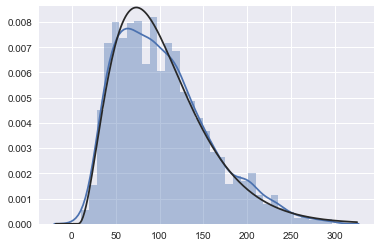

103.906520363


In [86]:
class Simulation:
    N = 20
    cycle = 30
    green_time = 15
    trip_length = 10
    saturation = .97
    arrival_rate = (saturation * green_time)/(trip_length *
                                              cycle)  # am i calculating this right?
    interval_generator = expon(scale=1./arrival_rate)

    def __init__(self):
        self.cars = deque()
        self.exited = deque()
        self.green = False
        self.time = 0
        self.queues = map(lambda x: Queue(
            x, self.getNextTime()), range(self.N))
        for (i, queue) in enumerate(self.queues):
            queue.next = self.queues[i+1] if i < (self.N-1) else self.queues[0]

    def getNextTime(self):
        return self.time + self.interval_generator.rvs(1)[0]

    def tick(self):
        self.time += 1

        if self.time % self.green_time == 0:  # this works because our green time is half our cycle length
            self.green = not self.green  # switch the signal

        if self.green:
            switches = []  # a list of which cars to move where

            for (i, queue) in enumerate(self.queues):
                if len(queue) > 0:  # if there are cars in the queue
                    car = queue.pop()  # pop the rightmost car off the queue
                    car.traverse(queue.ID)  # have the car traverse the queue
                    if car.traveled < self.trip_length:  # if it still has somewhere to go
                        switches.append((car, queue.next))
                    else:  # remove the car
                        car.setExitTime(self.time)
                        self.exited.append(car)

            for (car, receiving_queue) in switches:  # add traversed cars to the new queues
                receiving_queue.appendleft(car)

        for queue in self.queues:
            # keep a record of the queue length
            queue.recordQueueLength(self.time)
            if queue.nextTime <= self.time:
                car = Car(self.time)
                self.cars.append(car)
                queue.appendleft(car)
                queue.nextTime = self.getNextTime()

    def plotDelays(self):
        filtered = filter(lambda x: x.t_arrival > 3000, self.exited)
        delays = map(lambda x: x.t_exit-x.t_arrival, filtered)
        delays.sort()
        plt.cla()
        sns.distplot(delays,fit=stats.gamma)
        plt.show()
        print(np.mean(delays))
        return delays

sim = Simulation()

for i in range(8000):
    sim.tick()

delays = sim.plotDelays()


In [36]:
g = stats.lognorm.fit(delays)

In [38]:
a = stats.lognorm(*g)
a.